# Fisheres Biomass model derivation

The goal of this model is to derive a simple model of a harvested fish population that captures the effects of life history characteristics on the responce of the popualtion to environemtnal variability. There are two primary factors that I want the model to capture, variable recruitment due to changing environmetnal conditions, and differnt life histry strategies. Specifically I want to be able to represent the spectrum from slow growing long lived populations to fast growing short lived species. Capturing these two characteristics is crutial because fish populaiton act as filters of environmental varaibiltiy, and the nature of this filtering process depend on the life histry characteristics of the popuatlion. Developing a model that has information on both abundace and popuatlion structure also adds a useful layer of realism to my analysis of tock assements whcih provide informaiton on both of these factors.  

To capture these two processes I will develop a model that the biomass and size spectrum of the popuatlion and will show that this model can be simplified to track only the biomass and average size for a set of growth models. This reduction is critical because it will allow me to capture at least qualitativly the key processes of interst in a highly simplified model. There is a high premium for these simplifications because I plan to develop a bioeconomic model around this basic structure. 

## Life history characteristics 
### impact function and generation times 

I assume that fecundity is proportional to weight $w_t$ and that the growth of an individual is determined is given by an afine recursive relationship

$w_1 = w_r$

$w_{a+1} = (1-k)w_{\infty} + k w_a$.

This growth model is phenominological and is chosen because it allows for simplifying steos to be taken later on in the derivation. The primary issue with this model is that is over esitamtes the growth rate wen individuals are small. Given this model the weight fo in individual of age a is given by

$w_a = w_{\infty} - (1-k)^a(w_{\infty} - w_{r})$.

I assume that the mortality rate in each year is given by a constant factor $m$. Therefore survival to age $a$ is given by $s_a = (1-m)^a$.   

Given that fecundity is proportional to weight the survival curve can be combined with the growth curve to calcualte the "impact function" whcih describes how reproduction is spread out over an individuals life time 

$I_a = s_a*w_a = (1-m)^a\left[w_{\infty} - (1-k)^a(w_{\infty} - w_{r})\right]$.

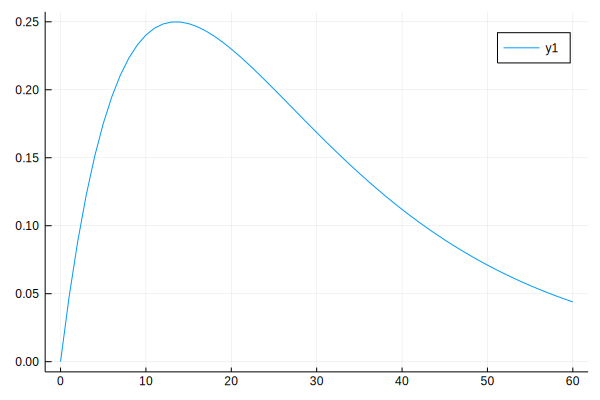

In [1]:
using Plots
# define LH parameters
k = 0.95



winfty = 1.0
wr = 0.0
m = 0.05
s(a,pars) = (1-pars[4])^a
w(a,pars) = pars[2] - (pars[2] - pars[3])*pars[1]^a
I(a,pars) = s(a,pars)*w(a,pars)

a = 0:60
pars = (k,winfty,wr,m)
Plots.plot(a,broadcast(x -> I(x, pars),a))

# Effect of life history paramters on generation times

The generation time for the model is given by 

$LEP = \sum_0^{\infty} I_a$

$T = \sum_0^{\infty} \frac{I_a}{LEP}$.

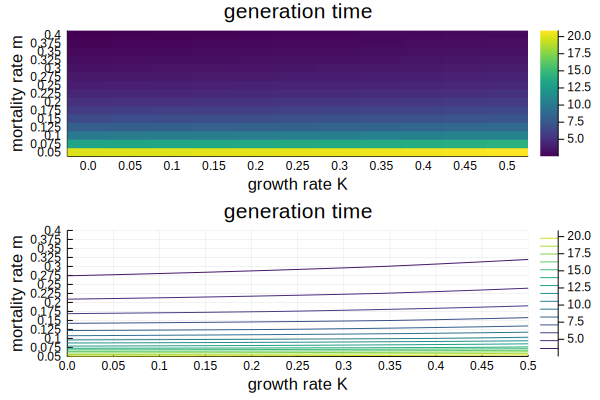

In [2]:
theme(:wong2)
function T(pars)
    a = 1:1000
    Ia = broadcast(x -> I(x,pars),a)
    return sum(a.*Ia)/sum(Ia)
end 

m_ = 0.05:0.025:0.4
k_ = 0.00:0.05:0.5
acc = zeros(length(m_), length(k_))
    
for i in 1:length(m_)
    for j in 1:length(k_)
        acc[i,j] = T((k_[j],1.0,0.0,m_[i]))
    end
end 

p1 = Plots.heatmap(acc,
    ylabel = " mortality rate m", 
    xlab = "growth rate K",
    title = "generation time",
    yticks = (1:length(m_), m_),
    xticks = (1:length(k_) , k_))
p2 = Plots.contour(acc,
    ylabel = " mortality rate m", 
    xlab = "growth rate K",
    title = "generation time",
    yticks = (1:length(m_), m_),
    xticks = (1:length(k_) , k_))
plot(p1,p2, layout = (2,1))

## Equilibrium and excess production 

In [3]:


using NLsolve

function excess_production(x,pars)
    k, winfty,wr,m,r,b,Bbar,dR = pars
    N = x[1]; B = x[2]
    return wr*r*B/(1 + b*B) + (1-m)*(N*winfty*(1-k)+k*B) - B 
end 


function excess_production_2_factor(x,pars)
    k, winfty,wr,m,r,b,Bbar,dR = pars
    N = x[1]; B = x[2]
    return (wr*r*B/(1 + b*B) , (1-m)*(N*winfty*(1-k)+k*B) - B )
end 

function sol_equib(x,F,pars)
    k, winfty,wr,m,r,b,Bbar,dR = pars
    N = x[1]; B = x[2]
    y1 = exp(-F)*(1-m)*N + r*B/(1 + b*B) -N 
    y2 = wr*r*B/(1 + b*B) + exp(-F)*(1-m)*(N*winfty*(1-k)+k*B)- B 
    return [y1,y2]
end 

function equib(F, pars)
    x0 = [100.0,100.0]
    sol = nlsolve(x -> sol_equib(x,F,pars), x0)
    return sol.zero
end 

equib (generic function with 1 method)

In [4]:
using Distributions
# LH parameters
k = 0.1
winfty = 5.0
wr = 0.0
m = 0.1

# SR paramters
r = 0.1
b_ = 0.05
Bbar = 1.0
dR = Distributions.Normal(0,0.1)

# calcualted paramters 
pars = (k,winfty,wr,m,r,b_,Bbar,dR)

eq = equib(0.0, pars)
eq

2-element Array{Float64,1}:
 15.506172877636699
 69.01098918069093

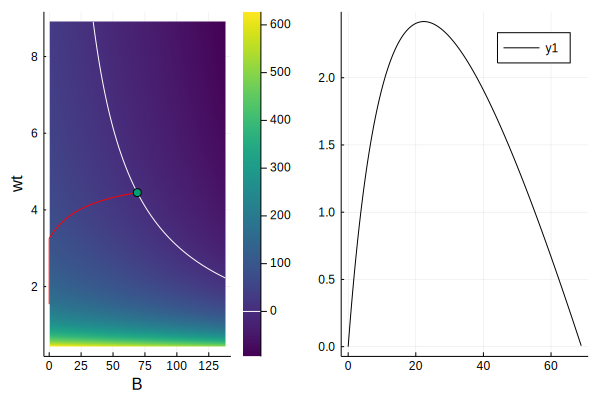

In [5]:
Bls = eq[2]*(0.01:0.005:2.0 )
Nls = eq[2]/eq[1] *  (0.1:0.005:2.0)

xp = zeros(length(Nls),length(Bls))
    
for i in 1:length(Nls)
    for j in 1:length(Bls)
        x = [eq[2] ./Nls[i],Bls[j]]
        xp[i,j] = excess_production(x,pars)
    end
end

Fls = 0.0001:0.001:1.0
Neqls = zeros(length(Fls))
    
Beqls = zeros(length(Fls))

xp_eq = zeros(length(Fls))
        
for i in 1:length(Fls)
    F = Fls[i]
    x = equib(F, pars)
    xp_eq[i] = excess_production(x,pars)
    Neqls[i] = x[2]/x[1] 
    Beqls[i] = x[2]
end 

p1 = Plots.heatmap(Bls,Nls,xp, ylab = "wt", xlab = "B")
Plots.contour!(p1, Bls,Nls,xp, color = "white", levels = [0.0])
Plots.plot!(p1,Beqls,Neqls, color = "Red")
Plots.scatter!(p1,[eq[2]],[eq[2]/eq[1]], legend = :none)

p2 = Plots.plot(Beqls, xp_eq)
plot(p1,p2)


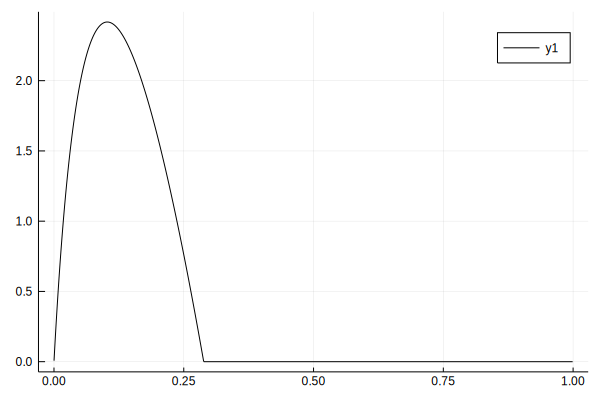

In [6]:
Plots.plot(Fls, xp_eq)

## Simplifying the LH parameters

The paramters can be simplified by assuming that the sum of the impact funciton of the life time egg production is always equal to the growth rate at low density $r$.  All of the other paramters will effect the shae of the impact function and cannot be reduced in this way. 

## Equilibrium, stability and eigen values

### Equilibrium conditions:

$\bar{N} = \frac{1}{m}\frac{r\bar{B}}{1+b\bar{B}}$

$\bar{B} = \frac{1}{b}\left(\frac{mw_rr+r(1-\rho)(1-m)w_{\infty}}{m\left(1-(1-m)\rho\right)} - 1\right)$

In [9]:
using Distributions
#### dynamics ####

# LH parameters
k = 0.85
winfty = 1.0
wr = 0.01
m = 0.2

# SR paramters
r = 0.75
Bbar = 1.0
dR = Distributions.Normal(0,0.1)

# calcualted paramters 
pars = (k,winfty,wr,m,r,Bbar,dR)
function b(pars) 
    k, winfty,wr,m,r,Bbar,dR = pars
    v = (m*wr*r + r*(1-k)*(1-m)*winfty)/(m*(1-(1-m)*k))
    return (v-1)/Bbar
end

# Update equations
function Nt(N,B,par)
    k, winfty,wr,m,r,Bbar,dR = pars
    return (1-m)*N + r*B/(1 + b(pars)*B) *exp(rand(dR))
end 

function Bt(N,B,pars)
    k, winfty,wr,m,r,Bbar,dR = pars
    return wr*r*B/(1 + b(pars)*B) + (1-m)*(N*winfty*(1-k)+k*B)
end


# equilibrium solutions
function Beq(pars)
    k, winfty,wr,m,r,Bbar,dR = pars
    v = (m*wr*r + r*(1-k)*(1-m)*winfty)/(m*(1-(1-m)*k))
    return (v-1)/b(pars)
end 

function Neq(pars)
    k, winfty,wr,m,r,Bbar,dR = pars
    return 1/m * r*Beq(pars)/(1+b(pars)*Beq(pars))
end 



# jacobian 

function Jeq(pars)
    k, winfty,wr,m,r,Bbar,dR = pars
    dNdN = (1-m)
    dNdB = r/(1+b(pars)*Beq(pars))^2
    dBdN = (1-m)*(1-k)*winfty
    dBdB = wr*r/(1+b(pars)*Beq(pars))^2 + (1-m)*k*Beq(pars)
    return [dNdN dNdB; dBdN dBdB]
end 

    


Jeq (generic function with 1 method)

In [10]:
using LinearAlgebra
# LH parameters
k1 = 0.95; winfty1 = 1.0; wr1 = 0.0; m1 = 0.1
k2 = 0.9; winfty2 = 1.0; wr2 = 0.0; m2 = 0.2
k3 = 0.8; winfty3 = 1.0; wr3 = 0.0; m3 = 0.3
# SR paramters
r1 = 0.5; Bbar1 = 1.0; dR1 = Distributions.Normal(0,0.2)
r2 = 1.1; Bbar2 = 1.0; dR2 = Distributions.Normal(0,0.2)
r3 = 1.5; Bbar3 = 1.0; dR3 = Distributions.Normal(0,0.2)
# calcualted paramters 
pars1 = (k1,winfty1,wr1,m1,r1,Bbar1,dR1)
pars2 = (k2,winfty2,wr2,m2,r2,Bbar2,dR2)
pars3 = (k3,winfty3,wr3,m3,r3,Bbar3,dR3)

println(LinearAlgebra.eigen(Jeq(pars1)).values)
println(LinearAlgebra.eigen(Jeq(pars2)).values)
println(LinearAlgebra.eigen(Jeq(pars3)).values)

[0.7782493352946972, 0.9767506647053028]
[0.5670327394702314, 0.9529672605297688]
[0.33356884682707755, 0.9264311531729224]


Main.BiomassDynamics

In [100]:
include("BiomassDynamics.jl")
# LH parameters
k = 0.9
winfty = 1.0
wr = 0.0
m = 0.15

# SR paramters
r = 0.5
b_= 0.5


# calcualted paramters 
pars = (k,winfty,wr,m,r,b_)
H, F = BiomassDynamics.Fmsy(pars)

(1.5436586912135509e-9, 0.21392830828110362)

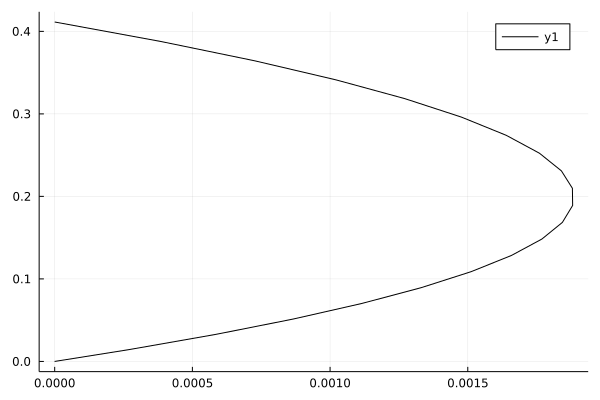

In [101]:
F = 0.0:0.001:1.0
H = broadcast(f -> BiomassDynamics.FtoH_eq(f,pars), F)
B = zeros(length(F))
    
i = 0 
for f in F
    i += 1
    B[i] = BiomassDynamics.equib(f, pars)[2]
end 
Plots.plot(H,B)

# Resiliance of adaptive control

In [4]:
15^5


759375

In [12]:
dat = zeros(15^5)
print(" ")

In [14]:

for i in 2:length(dat)
    dat[i] = dat[i] + dat[i-1]
end 

LoadError: [91mInterruptException:[39m

In [1]:
using Parameters

LoadError: [91mArgumentError: Package Parameters not found in current path:[39m
[91m- Run `import Pkg; Pkg.add("Parameters")` to install the Parameters package.[39m
